In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import glob
import time
import pickle
import random
import pathlib
import datetime

# from IPython import display
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from scipy.ndimage import gaussian_filter

2023-07-30 10:41:03.459664: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-30 10:41:03.523248: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-30 10:41:18.831400: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
RESULTS_FOLDER = 'results'

In [4]:
### Configuration
os.mkdir(RESULTS_FOLDER) if not os.path.isdir(RESULTS_FOLDER) else None
folders = ['all_exp_plots_g', 'all_exp_plots', 'exp_plots', 'model_weights', 'raw_exps', 'training_plots', 'all_val_plots', 'raw_vals']
for folder in folders:
    if(not os.path.isdir(f'{RESULTS_FOLDER}/{folder}')):
        os.mkdir(f'{RESULTS_FOLDER}/{folder}')

In [5]:
tf.random.set_seed(seed=20)

In [6]:
### Hyperparameters
BATCH_SIZE = 128
EPOCH = 100
# BATCH_SIZE = 32
# EPOCH = 1

### Load dataset 

In [7]:
### Normalization

In [8]:
def add_noise_blur(image, rows=128, cols=128):
    #add random noise
    scale = tf.random.uniform([1], minval = 0.01, maxval = 0.1, dtype = tf.float32 )
    noise = tf.random.normal([rows, cols, 1], mean = 0.0, stddev = 1.0)
    #blur with a random sigma
    # sigmaIn = np.random.uniform(low = 1.0, high = 2.0 )
    sigmaIn = tf.random.uniform(shape=[], minval = 1.0, maxval = 2.0 )
    #image = gaussian_filter(image, sigma = sigmaIn)
    noise = gaussian_filter(noise, sigma = sigmaIn.numpy())
    image *= (1.0 + scale*noise)
    #print("scale %f sigma %f" % (scale, sigmaIn))
    return image

In [9]:
def normalize(dataY):
    max = tf.reduce_max(dataY)
    min = tf.reduce_min(dataY)
    # dataY = dataY / tf.math.abs(min)
    dataY = (dataY - min)/(max - min)
    return dataY

In [10]:
def normalizeTarget(image, bFlag = False):
    image = (image - 1.0) / (5.0)
    if bFlag:
        image = 2.0*image - 1.0
    return image

In [11]:
### EoNormalization

In [12]:
def load(image_file, image_size=(128,128)):
    # input_image = np.fromfile(image_file, dtype = 'float32', sep="")
    input_image = tf.io.read_file(image_file)
    input_image = tf.io.decode_raw(input_image, tf.float32)
    input_image = tf.reshape(input_image, image_size)
    input_image = tf.expand_dims(input_image, -1)
    return input_image

In [13]:
def normalize_val(image, target):
    input_image = add_noise_blur(image)
    return input_image , target

In [14]:
def load_image_train(image_file, target_file):
    input_image = load(image_file)
    target_image = load(target_file)
    input_image = normalize(input_image)
    return input_image , target_image 

In [15]:
def load_image_val(image_file, target_file):    
    input_image = load(image_file)
    target_image = load(target_file)
    # input_image = add_noise_blur(image_file)
    input_image = normalize(input_image)
    return input_image , target_image 

In [16]:
def check_count(log_path):
    soft = 0
    hard = 0
    for lp in log_path:
        with open(lp) as f:
            data = f.read()
        data = data.split(' ')
        mod = data[9]
        assert mod == 'mod1'
        mod_value = float(data[10].splitlines()[0])
        if mod_value < 1.0:
            soft = soft + 1
        if mod_value > 1.0:
            hard = hard + 1
    return soft, hard

In [17]:
def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=False, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [18]:
# input_path = glob.glob('data/TrainData*/*/uY_128x128*.raw')
# target_path = glob.glob('data/TrainData*/*/modulus_128x128*.raw')
# # input_path.sort(key= lambda x: int(x.split('/')[-2]))
# # target_path.sort(key= lambda x: int(x.split('/')[-2]))

In [19]:
input_path = glob.glob('alldata/TrainData/*/uY_128x128.raw')
target_path = glob.glob('alldata/TrainData/*/modulus_128x128.raw')
log_path = glob.glob('alldata/TrainData/*/logFile.txt')
input_path.sort(key= lambda x: int(x.split('/')[-2]))
target_path.sort(key= lambda x: int(x.split('/')[-2]))
log_path.sort(key= lambda x: int(x.split('/')[-2]))

In [20]:
len(input_path)

10000

In [21]:
len(target_path)

10000

In [22]:
check_count(log_path)

(4966, 5034)

In [23]:
input_val_path = glob.glob('alldata/ValData/*/uY_128x128.raw')
target_val_path = glob.glob('alldata/ValData/*/modulus_128x128.raw')
log_val_path = glob.glob('alldata/ValData/*/logFile.txt')
input_val_path.sort(key= lambda x: int(x.split('/')[-2]))
target_val_path.sort(key= lambda x: int(x.split('/')[-2]))
log_val_path.sort(key= lambda x: int(x.split('/')[-2]))

In [24]:
check_count(log_val_path)

(495, 505)

In [25]:
# train_dataset
train_dataset = tf.data.Dataset.from_tensor_slices((input_path, target_path))
train_dataset = train_dataset.map(load_image_train)
train_dataset = train_dataset.shuffle(buffer_size=len(input_path)) 
train_dataset = train_dataset.batch(BATCH_SIZE)

2023-07-30 10:44:22.237062: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38201 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:1b:00.0, compute capability: 8.0
2023-07-30 10:44:22.238249: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6838 MB memory:  -> device: 1, name: Tesla P4, pci bus id: 0000:1c:00.0, compute capability: 6.1


In [26]:
len(train_dataset)

79

In [27]:
# train_dataset, val_dataset, test_dataset = get_dataset_partitions_tf(train_dataset, len(train_dataset))
# print(len(train_dataset), len(val_dataset), len(test_dataset))

In [28]:
## val_dataset
val_dataset = tf.data.Dataset.from_tensor_slices((input_val_path, target_val_path))
val_dataset = val_dataset.map(load_image_val)
# val_dataset = val_dataset.shuffle(buffer_size=len(input_val_path)) 
# val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(1)

In [29]:
# print(len(dataset))
print(len(train_dataset))
print(len(val_dataset))
# print(len(test_dataset))

79
1000


In [30]:
a = next(iter(train_dataset))
print(len(a))
print(a[0].shape)
print(a[1].shape)

2023-07-30 10:44:23.045102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [10000]
	 [[{{node Placeholder/_1}}]]
2023-07-30 10:44:33.154115: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 550 of 10000
2023-07-30 10:44:43.081376: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1205 of 10000
2023-07-30 10:44:53.061384: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2117 of 10000
2023-07-30 10:45:03.055199: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3081 of 10000
2023-07-30 10:45:13.056540: I tensorflow/core/kernel

2
(128, 128, 128, 1)
(128, 128, 128, 1)


2023-07-30 10:46:22.779872: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


In [31]:
inp, re = a[0][0], a[1][0]

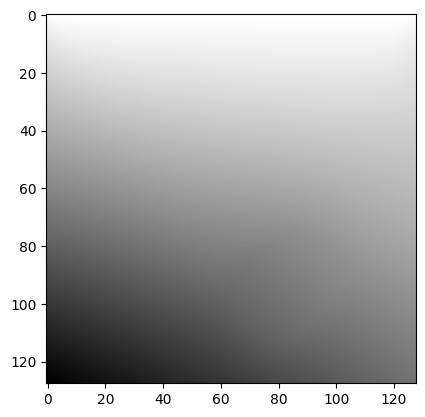

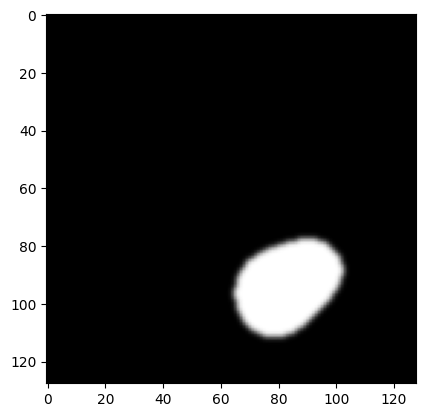

In [32]:
plt.figure()
plt.imshow(inp, cmap='gray')
plt.figure()
plt.imshow(re, cmap='gray')

In [33]:
len(val_dataset)

1000

In [34]:
# val_dataset = val_dataset.batch(1)

In [35]:
len(val_dataset)

1000

### Generator Model

In [36]:
OUTPUT_CHANNELS = 1

In [37]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result

In [38]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

2023-07-30 10:46:27.378789: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8902
2023-07-30 10:46:31.524276: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:109] Couldn't get ptxas version : FAILED_PRECONDITION: Couldn't get ptxas/nvlink version string: INTERNAL: Running ptxas --version returned 32512
2023-07-30 10:46:31.614040: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:317] INTERNAL: ptxas exited with non-zero error code 32512, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


(1, 64, 64, 3)


In [39]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

In [40]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 128, 128, 3)


In [41]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[128, 128, 1])

    # down_stack = [
    #     downsample(64, 3, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    #     downsample(128, 3),  # (batch_size, 64, 64, 128)
    #     downsample(256, 3),  # (batch_size, 32, 32, 256)
    #     downsample(512, 3),  # (batch_size, 16, 16, 512)
    #     downsample(512, 3),  # (batch_size, 8, 8, 512)
    #     downsample(512, 3),  # (batch_size, 4, 4, 512)
    #     downsample(512, 3),  # (batch_size, 2, 2, 512)
    #     # downsample(512, 4),  # (batch_size, 1, 1, 512)
    # ]
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
        downsample(128, 4),  # (batch_size, 64, 64, 128)
        downsample(256, 4),  # (batch_size, 32, 32, 256)
        downsample(512, 4),  # (batch_size, 16, 16, 512)
        downsample(512, 4),  # (batch_size, 8, 8, 512)
        downsample(512, 4),  # (batch_size, 4, 4, 512)
        downsample(512, 4),  # (batch_size, 2, 2, 512)
        # downsample(512, 4),  # (batch_size, 1, 1, 512)
    ]

    # up_stack = [
    #     # upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    #     upsample(512, 3, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    #     upsample(512, 3, apply_dropout=False),  # (batch_size, 8, 8, 1024)
    #     upsample(512, 3),  # (batch_size, 16, 16, 1024)
    #     upsample(256, 3),  # (batch_size, 32, 32, 512)
    #     upsample(128, 3),  # (batch_size, 64, 64, 256)
    #     upsample(64, 3),  # (batch_size, 128, 128, 128)
    # ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
        upsample(512, 4),  # (batch_size, 16, 16, 1024)
        upsample(256, 4),  # (batch_size, 32, 32, 512)
        upsample(128, 4),  # (batch_size, 64, 64, 256)
        # upsample(64, 4),  # (batch_size, 128, 128, 128)
    ]

    
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 3,
                                            strides=2,
                                            padding='same',
                                            kernel_initializer=initializer,
                                            activation='sigmoid')  # (batch_size, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    # x = last(x)
    # x = 1.0 + (10.0 - 1.0)*x 

    upsampling = tf.keras.layers.UpSampling2D(size=2, interpolation = 'bilinear')
    # last_conv = tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='same', activation='relu')
    last_conv = tf.keras.layers.Conv2D(1, kernel_size=3, strides=1, padding='same', activation='sigmoid')
    multiply = tf.keras.layers.Lambda(lambda x: 0.1 + (5.0 - 0.1)*x)
    
    x = upsampling(x)
    x = last_conv(x)
    x = multiply(x)
    
    # x = 0.1 + (10.0 - 0.1)*x
    # this one for both!

    return tf.keras.Model(inputs=inputs, outputs=x)

In [42]:
# Visualizing generator architecture
generator = Generator()
# tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

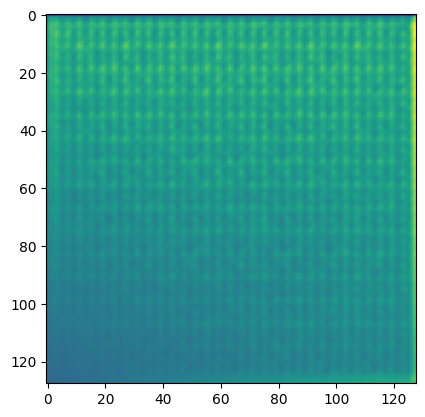

In [43]:
# Testing the generator
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

In [44]:
# gen_output[0]

In [45]:
gen_output.shape

TensorShape([1, 128, 128, 1])

In [46]:
# Generator loss
LAMBDA = 100
loss_object = tf.keras.losses.MeanSquaredError()
loss_tracker = tf.keras.metrics.Mean(name="loss")
val_loss_tracker = tf.keras.metrics.Mean(name="loss")

In [47]:
def generator_loss(gen_output, target):
    #Possible addition: regularizer
    gan_loss = loss_object(gen_output, target)
    return gan_loss

In [48]:
# tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64, to_file='results/model.png')

In [49]:
generator_loss(gen_output, re[tf.newaxis,...])

<tf.Tensor: shape=(), dtype=float32, numpy=2.3445272>

In [50]:
re[tf.newaxis,...].shape

TensorShape([1, 128, 128, 1])

In [51]:
gen_output.shape

TensorShape([1, 128, 128, 1])

### Optimizers and checkpoints

In [52]:
generator_optimizer = tf.keras.optimizers.legacy.Adam(2e-4, beta_1=0.5)
# discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [53]:
checkpoint_dir = 'training_checkpoints/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 generator=generator,
                                )

In [54]:
class MidPointLogNorm(mcolors.LogNorm):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        mcolors.LogNorm.__init__(self,vmin=vmin, vmax=vmax, clip=clip)
        self.midpoint=midpoint
    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [np.log(self.vmin), np.log(self.midpoint), np.log(self.vmax)], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(np.log(value), x, y))

In [55]:
def generate_images(model, test_input, tar, epoch, step):
    prediction = model(test_input, training=False)
    display_list = [test_input[0], tar[0], prediction[0]]
    mse_loss = tf.keras.losses.MeanSquaredError()(tar[0], prediction[0]).numpy()
    mape_loss = tf.keras.losses.MeanAbsolutePercentageError()(tar[0], prediction[0]).numpy()
    title = ['Input Image', 'Ground Truth', f'Predicted {mse_loss:.2f} {mape_loss:.2f}%']
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i], cmap='gray')
        plt.colorbar(location='bottom')
        plt.axis('off')
    plt.savefig(f'results/training_plots/{epoch}-{step}.png')

In [98]:
plt.tight_layout()
def generate_images8(model, test_input, tar, epoch, step):
    prediction = model(test_input, training=False)
    x = prediction.numpy()
    # if np.amax(x) > 1.0:
    #     x[x < 1.0] = 1.0
    # else:
    #     x[x > 1.0] = 1.0

    display_list = [test_input[0], tar[0], x[0]]
    mse_loss = tf.keras.losses.MeanSquaredError()(tar[0], prediction[0]).numpy()
    mape_loss = tf.keras.losses.MeanAbsolutePercentageError()(tar[0], prediction[0]).numpy()
    title = ['Input Image', 'Ground Truth', f'Predicted'] #{mse_loss:.2f} {mape_loss:.2f}%
    plt.figure(figsize=(15, 8))

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i], fontsize=25)
        if i==0:
            plt.imshow(display_list[i], cmap='bwr')
            plt.colorbar(location='bottom',pad=0.1)
        else:
            plt.imshow(display_list[i], cmap='bwr', norm= MidPointLogNorm(vmin=0.01, vmax=5.0, midpoint=1.0))
            plt.colorbar(location='bottom',pad=0.1)
        plt.axis('on')
    plt.savefig(f'{RESULTS_FOLDER}/training_plots/{epoch}-{step}.png', bbox_inches='tight')
    plt.close()

    # plt.imshow(target[i][0], cmap='bwr', norm= MidPointLogNorm(vmin=0.1, vmax=5, midpoint=1))
    # plt.colorbar(location='bottom', pad=0.05)
    # plt.suptitle('Modulus distribution', x=0.5, y = 0.48, fontsize=15)

<Figure size 640x480 with 0 Axes>

In [57]:
for example_input, example_target in val_dataset.take(1):
    generate_images8(generator, example_input, example_target,6,6)

2023-07-30 10:46:35.226993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-30 10:46:35.227236: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]


In [58]:
# for i, (example_input, example_target) in enumerate(val_dataset.take(1000)):
#     if i+1 == 49 or i+1 == 174:
#         generate_images8(generator, example_input, example_target,i+1,i+1)

### Training

In [59]:
MODEL_PATH = f"{RESULTS_FOLDER}/model_weights/mse_model"
BEST_PATH = f"{RESULTS_FOLDER}/model_weights/best_mse_model"

In [60]:
log_dir=f"{RESULTS_FOLDER}/logs/"
summary_writer = tf.summary.create_file_writer(log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
gen_total_loss_list = []
gen_val_loss_list = []

In [61]:
# @tf.function
def train_step(input_image, target, step):
    with tf.GradientTape() as gen_tape:
        gen_output = generator(input_image, training=True)
        gen_total_loss = generator_loss(gen_output, target)

    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    
    if step%5 == 0:
        gen_total_loss_list.append(gen_total_loss.numpy())
        loss_tracker.update_state(gen_total_loss)
    # print(f'Result:{loss_tracker.result()}')

    # with summary_writer.as_default():
    #     tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)

In [62]:
def val_step(input_image, target, step):
    gen_output = generator(input_image, training=False)
    gen_val_loss = generator_loss(gen_output, target)
    gen_val_loss_list.append(gen_val_loss)
    val_loss_tracker.update_state(gen_val_loss)

    # print(gen_val_loss)

In [63]:
min_val_loss = 100000;

In [64]:
epoch_wise_train_loss = []
epoch_wise_val_loss = []

In [65]:
def fit(train_ds, val_ds, epochs, steps=10*len(train_dataset)):
    example_input, example_target = next(iter(train_ds.take(1)))
    start = time.time()
    min_val_loss = 1000
    
    for epoch in range(epochs):
        for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
            train_step(input_image, target, step)
            if (step)%100==0:
                # 3 times per batch 
                for (input_image, target) in val_ds.take(500):
                    val_step(input_image, target, step)
            # display.clear_output(wait=True)

        ## Save best model
        current_loss = val_loss_tracker.result().numpy()
        print("current loss",current_loss)
        print("Min vall loss",min_val_loss)
        if(current_loss < min_val_loss and epoch > 2):
            min_val_loss = current_loss
            generator.save_weights(BEST_PATH)
            print(f"Saving best weight with val loss:{min_val_loss} to {BEST_PATH}")

        if (epoch) % 10 == 0:
            # display.clear_output(wait=True)
            if epoch != 0:
                print(f'Time taken for 10 epochs: {time.time()-start:.2f} sec\n')
            start = time.time()
            generate_images(generator, example_input, example_target, epoch, step)
            print(f"Reached epoch: {epoch}")
            # generate_images2(generator, exp_img, epoch, step)    

        # Save (checkpoint) the model every 25 EPOCH
        if (epoch)%25 == 0:
            print(f"Saving checkpoint at epoch:{epoch}")
            checkpoint.save(file_prefix=checkpoint_prefix)
            print(f"Step: {step}, Train Loss:{loss_tracker.result()} , Val Loss:{val_loss_tracker.result()}")
        
        print(f"Epoch: {epoch}, Train Loss:{loss_tracker.result()} , Val Loss:{val_loss_tracker.result()}")
        epoch_wise_train_loss.append(loss_tracker.result())
        epoch_wise_val_loss.append(val_loss_tracker.result())
        loss_tracker.reset_states()
        val_loss_tracker.reset_states()

    generator.save_weights(MODEL_PATH)
    print(f'\nModel saved to: {MODEL_PATH}')
    print('min_val_loss',min_val_loss)
    with open(f'{RESULTS_FOLDER}/loss.txt','w') as f:
        f.write(str(min_val_loss))
        f.write("epoch")
        f.write(str(epoch))

2023-07-28 20:35:55.831711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [10000]
	 [[{{node Placeholder/_0}}]]
2023-07-28 20:35:58.036252: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-28 20:35:58.063308: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [10000]
	 [[{{node Placeholder/_5}}]]
2023-07-28 20:36:25.969674: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:530] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This ma

current loss 0.8577072
Min vall loss 1000
Reached epoch: 0
Saving checkpoint at epoch:0
Step: 789, Train Loss:0.06340323388576508 , Val Loss:0.8577072024345398
Epoch: 0, Train Loss:0.06340323388576508 , Val Loss:0.8577072024345398


2023-07-28 20:41:28.648688: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-28 20:41:28.653033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [10000]
	 [[{{node Placeholder/_4}}]]
2023-07-28 20:41:31.350185: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-28 20:42:07.543927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.5548771
Min vall loss 1000
Epoch: 1, Train Loss:0.011678358539938927 , Val Loss:0.5548771023750305


2023-07-28 20:46:21.753251: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-28 20:46:21.756829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [10000]
	 [[{{node Placeholder/_5}}]]
2023-07-28 20:46:24.093903: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-28 20:47:01.189630: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.018635787
Min vall loss 1000
Epoch: 2, Train Loss:0.005951732397079468 , Val Loss:0.018635787069797516


2023-07-28 20:51:12.978307: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-28 20:51:12.983112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [10000]
	 [[{{node Placeholder/_4}}]]
2023-07-28 20:51:15.684986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-28 20:51:53.131551: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.009035932
Min vall loss 1000
Saving best weight with val loss:0.009035931900143623 to results/model_weights/best_mse_model
Epoch: 3, Train Loss:0.00533153023570776 , Val Loss:0.009035931900143623


2023-07-28 20:56:09.417312: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-28 20:56:09.421216: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [10000]
	 [[{{node Placeholder/_4}}]]
2023-07-28 20:56:12.165396: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-28 20:56:48.782209: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.007799718
Min vall loss 0.009035932
Saving best weight with val loss:0.00779971806332469 to results/model_weights/best_mse_model
Epoch: 4, Train Loss:0.0038249827921390533 , Val Loss:0.00779971806332469


2023-07-28 21:01:03.570751: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-28 21:01:03.575632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [10000]
	 [[{{node Placeholder/_5}}]]
2023-07-28 21:01:06.106348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-28 21:01:42.173184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.112027876
Min vall loss 0.007799718
Epoch: 5, Train Loss:0.008884218521416187 , Val Loss:0.11202787607908249


2023-07-28 21:05:53.607122: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-28 21:05:53.612137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [10000]
	 [[{{node Placeholder/_4}}]]
2023-07-28 21:05:56.233834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-28 21:06:33.211686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.06528904
Min vall loss 0.007799718
Epoch: 6, Train Loss:0.003934287466108799 , Val Loss:0.06528904289007187


2023-07-28 21:10:50.454476: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-28 21:10:50.458702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [10000]
	 [[{{node Placeholder/_4}}]]
2023-07-28 21:10:53.060897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-28 21:11:29.536996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.010117912
Min vall loss 0.007799718
Epoch: 7, Train Loss:0.0027480872813612223 , Val Loss:0.010117911733686924


2023-07-28 21:15:46.817144: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-28 21:15:46.821115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [10000]
	 [[{{node Placeholder/_4}}]]
2023-07-28 21:15:49.565815: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-28 21:16:27.046070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.0323298
Min vall loss 0.007799718
Epoch: 8, Train Loss:0.002873486839234829 , Val Loss:0.032329801470041275


2023-07-28 21:22:42.931834: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-28 21:22:42.935860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [10000]
	 [[{{node Placeholder/_5}}]]
2023-07-28 21:22:45.591959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-28 21:23:21.273601: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.111849256
Min vall loss 0.007799718
Epoch: 9, Train Loss:0.0054935552179813385 , Val Loss:0.11184925585985184


2023-07-28 21:27:39.037890: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-28 21:27:39.043969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [10000]
	 [[{{node Placeholder/_4}}]]
2023-07-28 21:27:41.760783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-28 21:28:18.695047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.0063446015
Min vall loss 0.007799718
Saving best weight with val loss:0.006344601511955261 to results/model_weights/best_mse_model
Time taken for 10 epochs: 3069.23 sec

Reached epoch: 10
Epoch: 10, Train Loss:0.0021493243984878063 , Val Loss:0.006344601511955261


2023-07-28 21:32:36.371938: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-28 21:32:36.375552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [10000]
	 [[{{node Placeholder/_4}}]]
2023-07-28 21:32:39.032300: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-28 21:33:16.019461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.0059077214
Min vall loss 0.0063446015
Saving best weight with val loss:0.005907721351832151 to results/model_weights/best_mse_model
Epoch: 11, Train Loss:0.0017539100954309106 , Val Loss:0.005907721351832151


2023-07-28 21:37:27.886663: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-28 21:37:27.892135: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [10000]
	 [[{{node Placeholder/_5}}]]
2023-07-28 21:37:30.689645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-28 21:38:07.718581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.028404148
Min vall loss 0.0059077214
Epoch: 12, Train Loss:0.003757634898647666 , Val Loss:0.028404148295521736


2023-07-28 21:42:24.573027: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-28 21:42:24.577563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [10000]
	 [[{{node Placeholder/_5}}]]
2023-07-28 21:42:27.130672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-28 21:43:04.111265: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.018767405
Min vall loss 0.0059077214
Epoch: 13, Train Loss:0.0016121066873893142 , Val Loss:0.018767405301332474


2023-07-28 21:47:24.921087: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-28 21:47:24.925020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [10000]
	 [[{{node Placeholder/_5}}]]
2023-07-28 21:47:27.564734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-28 21:48:05.077662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.018745173
Min vall loss 0.0059077214
Epoch: 14, Train Loss:0.0016028460813686252 , Val Loss:0.018745172768831253


2023-07-28 21:52:29.501274: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-28 21:52:29.506231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [10000]
	 [[{{node Placeholder/_4}}]]
2023-07-28 21:52:32.283237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-28 21:53:09.497226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.009637729
Min vall loss 0.0059077214
Epoch: 15, Train Loss:0.001427948009222746 , Val Loss:0.00963772926479578


2023-07-28 21:57:29.486109: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-28 21:57:29.489313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [10000]
	 [[{{node Placeholder/_4}}]]
2023-07-28 21:57:32.120920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-28 21:58:10.157293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.0164148
Min vall loss 0.0059077214
Epoch: 16, Train Loss:0.0014376952312886715 , Val Loss:0.01641480065882206


2023-07-28 22:02:31.064190: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-28 22:02:31.067150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [10000]
	 [[{{node Placeholder/_5}}]]
2023-07-28 22:02:33.643468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-28 22:03:10.946223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.076249205
Min vall loss 0.0059077214
Epoch: 17, Train Loss:0.0032770445104688406 , Val Loss:0.07624920457601547


2023-07-28 22:12:23.218795: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-28 22:12:23.222860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [10000]
	 [[{{node Placeholder/_4}}]]
2023-07-28 22:12:25.988391: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-28 22:13:03.326286: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.006070824
Min vall loss 0.0059077214
Epoch: 18, Train Loss:0.0013600070960819721 , Val Loss:0.00607082387432456


2023-07-28 22:17:24.329394: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-28 22:17:24.334417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [10000]
	 [[{{node Placeholder/_5}}]]
2023-07-28 22:17:27.103428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-28 22:18:04.676674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.0076725055
Min vall loss 0.0059077214
Epoch: 19, Train Loss:0.0018428971525281668 , Val Loss:0.0076725054532289505


2023-07-28 22:22:30.767487: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-28 22:22:30.772216: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [10000]
	 [[{{node Placeholder/_5}}]]
2023-07-28 22:22:33.387923: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-28 22:23:10.297685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.008175427
Min vall loss 0.0059077214
Time taken for 10 epochs: 3297.15 sec

Reached epoch: 20
Epoch: 20, Train Loss:0.001190466107800603 , Val Loss:0.008175427094101906


2023-07-28 22:27:33.873018: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-28 22:27:33.877437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [10000]
	 [[{{node Placeholder/_5}}]]
2023-07-28 22:27:36.667026: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-28 22:28:14.880968: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.10507782
Min vall loss 0.0059077214
Epoch: 21, Train Loss:0.001302690478041768 , Val Loss:0.1050778180360794


2023-07-28 22:32:34.908645: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-28 22:32:34.912450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [10000]
	 [[{{node Placeholder/_4}}]]
2023-07-28 22:32:37.557542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-28 22:33:14.749213: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.0039583016
Min vall loss 0.0059077214
Saving best weight with val loss:0.003958301618695259 to results/model_weights/best_mse_model
Epoch: 22, Train Loss:0.001077219843864441 , Val Loss:0.003958301618695259


2023-07-28 22:37:36.876713: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-28 22:37:36.882151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [10000]
	 [[{{node Placeholder/_5}}]]
2023-07-28 22:37:39.450710: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-28 22:38:17.140264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.014308761
Min vall loss 0.0039583016
Epoch: 23, Train Loss:0.0010120933875441551 , Val Loss:0.01430876087397337


2023-07-28 22:42:39.399325: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-28 22:42:39.402483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [10000]
	 [[{{node Placeholder/_5}}]]
2023-07-28 22:42:41.916313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-28 22:43:18.039166: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.012417613
Min vall loss 0.0039583016
Epoch: 24, Train Loss:0.0013641247060149908 , Val Loss:0.012417612597346306


2023-07-28 22:47:39.293302: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-28 22:47:39.298438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [10000]
	 [[{{node Placeholder/_4}}]]
2023-07-28 22:47:42.194693: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-28 22:48:19.572180: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.0065523386
Min vall loss 0.0039583016
Saving checkpoint at epoch:25
Step: 789, Train Loss:0.0009557523881085217 , Val Loss:0.006552338600158691
Epoch: 25, Train Loss:0.0009557523881085217 , Val Loss:0.006552338600158691


2023-07-28 22:52:39.628998: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-28 22:52:39.633520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [10000]
	 [[{{node Placeholder/_4}}]]
2023-07-28 22:52:42.247287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-28 22:53:19.497673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.007685214
Min vall loss 0.0039583016
Epoch: 26, Train Loss:0.0009355697548016906 , Val Loss:0.007685213815420866


2023-07-28 22:57:35.133535: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-28 22:57:35.138567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [10000]
	 [[{{node Placeholder/_4}}]]
2023-07-28 22:57:37.848792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-28 22:58:14.577242: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.09722182
Min vall loss 0.0039583016
Epoch: 27, Train Loss:0.0032427043188363314 , Val Loss:0.09722182154655457


2023-07-28 23:02:30.030093: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-28 23:02:30.035744: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [10000]
	 [[{{node Placeholder/_5}}]]
2023-07-28 23:02:32.620647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-28 23:03:08.730486: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.0049465788
Min vall loss 0.0039583016
Epoch: 28, Train Loss:0.0009385774610564113 , Val Loss:0.00494657875970006


2023-07-28 23:11:54.127938: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-28 23:11:54.131349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [10000]
	 [[{{node Placeholder/_4}}]]
2023-07-28 23:11:56.416522: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-28 23:12:32.574092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.011521165
Min vall loss 0.0039583016
Epoch: 29, Train Loss:0.0009096835274249315 , Val Loss:0.011521165259182453


2023-07-28 23:16:45.930430: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-28 23:16:45.933706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [10000]
	 [[{{node Placeholder/_4}}]]
2023-07-28 23:16:48.259109: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-28 23:17:24.224681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.017230215
Min vall loss 0.0039583016
Time taken for 10 epochs: 3240.66 sec

Reached epoch: 30
Epoch: 30, Train Loss:0.0008255043649114668 , Val Loss:0.017230214551091194


2023-07-28 23:21:34.190511: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-28 23:21:34.195176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [10000]
	 [[{{node Placeholder/_4}}]]
2023-07-28 23:21:36.760161: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-28 23:22:12.259447: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.031218005
Min vall loss 0.0039583016
Epoch: 31, Train Loss:0.00101201341021806 , Val Loss:0.03121800534427166


2023-07-28 23:26:26.766027: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-28 23:26:26.769425: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [10000]
	 [[{{node Placeholder/_5}}]]
2023-07-28 23:26:29.118184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-28 23:27:05.439607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.006256136
Min vall loss 0.0039583016
Epoch: 32, Train Loss:0.0010552731109783053 , Val Loss:0.0062561361119151115


2023-07-28 23:31:21.966968: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-28 23:31:21.971017: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [10000]
	 [[{{node Placeholder/_5}}]]
2023-07-28 23:31:24.842708: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-28 23:32:00.383014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.006934935
Min vall loss 0.0039583016
Epoch: 33, Train Loss:0.0007238068501465023 , Val Loss:0.006934935227036476


2023-07-28 23:36:16.675108: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-28 23:36:16.679015: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [10000]
	 [[{{node Placeholder/_5}}]]
2023-07-28 23:36:19.401171: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-28 23:36:56.428734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.012567491
Min vall loss 0.0039583016
Epoch: 34, Train Loss:0.0008630095398984849 , Val Loss:0.01256749127060175


2023-07-28 23:41:15.282247: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-28 23:41:15.286745: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [10000]
	 [[{{node Placeholder/_4}}]]
2023-07-28 23:41:17.847857: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-28 23:41:54.616947: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.01611631
Min vall loss 0.0039583016
Epoch: 35, Train Loss:0.001011854619719088 , Val Loss:0.01611630991101265


2023-07-28 23:46:11.653048: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-28 23:46:11.657792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [10000]
	 [[{{node Placeholder/_5}}]]
2023-07-28 23:46:14.206023: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-28 23:46:50.419197: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.0056827487
Min vall loss 0.0039583016
Epoch: 36, Train Loss:0.0007217237143777311 , Val Loss:0.0056827487424016


2023-07-28 23:51:06.881254: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-28 23:51:06.884731: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [10000]
	 [[{{node Placeholder/_5}}]]
2023-07-28 23:51:09.333690: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-28 23:51:46.706816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.007928192
Min vall loss 0.0039583016
Epoch: 37, Train Loss:0.000699301774147898 , Val Loss:0.007928191684186459


2023-07-28 23:56:11.369107: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-28 23:56:11.372380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [10000]
	 [[{{node Placeholder/_5}}]]
2023-07-28 23:56:13.794617: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-28 23:56:51.357887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.028685272
Min vall loss 0.0039583016
Epoch: 38, Train Loss:0.0007042314973659813 , Val Loss:0.028685271739959717


2023-07-29 00:05:55.197204: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 00:05:55.202292: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [10000]
	 [[{{node Placeholder/_5}}]]
2023-07-29 00:05:57.634859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 00:06:35.709080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.00791097
Min vall loss 0.0039583016
Epoch: 39, Train Loss:0.000795672764070332 , Val Loss:0.00791096966713667


2023-07-29 00:11:02.456817: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 00:11:02.460769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [10000]
	 [[{{node Placeholder/_5}}]]
2023-07-29 00:11:05.154612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 00:11:42.307524: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.0028968065
Min vall loss 0.0039583016
Saving best weight with val loss:0.0028968064580112696 to results/model_weights/best_mse_model
Time taken for 10 epochs: 3272.90 sec

Reached epoch: 40
Epoch: 40, Train Loss:0.0006402868893928826 , Val Loss:0.0028968064580112696


2023-07-29 00:16:07.143828: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 00:16:07.148521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [10000]
	 [[{{node Placeholder/_4}}]]
2023-07-29 00:16:09.784554: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 00:16:47.845692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.005385613
Min vall loss 0.0028968065
Epoch: 41, Train Loss:0.0006633115117438138 , Val Loss:0.005385613068938255


2023-07-29 00:21:13.691565: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 00:21:13.695959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [10000]
	 [[{{node Placeholder/_5}}]]
2023-07-29 00:21:16.394612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 00:21:54.026368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.009744125
Min vall loss 0.0028968065
Epoch: 42, Train Loss:0.0006723325932398438 , Val Loss:0.009744125418365002


2023-07-29 00:26:15.959629: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 00:26:15.963371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [10000]
	 [[{{node Placeholder/_5}}]]
2023-07-29 00:26:18.737463: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 00:26:55.619988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.018939557
Min vall loss 0.0028968065
Epoch: 43, Train Loss:0.0006445794133469462 , Val Loss:0.018939556553959846


2023-07-29 00:31:15.972446: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 00:31:15.975634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [10000]
	 [[{{node Placeholder/_4}}]]
2023-07-29 00:31:18.672376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 00:31:56.763774: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.005584291
Min vall loss 0.0028968065
Epoch: 44, Train Loss:0.0006825688178651035 , Val Loss:0.005584291182458401


2023-07-29 00:36:13.604418: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 00:36:13.607638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [10000]
	 [[{{node Placeholder/_4}}]]
2023-07-29 00:36:16.147822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 00:36:53.465157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.08585123
Min vall loss 0.0028968065
Epoch: 45, Train Loss:0.0008490420295856893 , Val Loss:0.08585122972726822


2023-07-29 00:41:10.150452: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 00:41:10.154391: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [10000]
	 [[{{node Placeholder/_5}}]]
2023-07-29 00:41:12.778221: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 00:41:49.218750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.0025585257
Min vall loss 0.0028968065
Saving best weight with val loss:0.002558525651693344 to results/model_weights/best_mse_model
Epoch: 46, Train Loss:0.0006898273131810129 , Val Loss:0.002558525651693344


2023-07-29 00:46:07.888152: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 00:46:07.891919: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [10000]
	 [[{{node Placeholder/_5}}]]
2023-07-29 00:46:10.588885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 00:46:47.970812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.0027707086
Min vall loss 0.0025585257
Epoch: 47, Train Loss:0.0005345252575352788 , Val Loss:0.002770708641037345


2023-07-29 00:51:08.021302: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 00:51:08.026316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [10000]
	 [[{{node Placeholder/_5}}]]
2023-07-29 00:51:10.690072: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 00:51:48.215506: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.0065011987
Min vall loss 0.0025585257
Epoch: 48, Train Loss:0.000506172189489007 , Val Loss:0.006501198746263981


2023-07-29 00:59:27.308935: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 00:59:27.312729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [10000]
	 [[{{node Placeholder/_5}}]]
2023-07-29 00:59:30.042738: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 01:00:08.083613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.011845527
Min vall loss 0.0025585257
Epoch: 49, Train Loss:0.0007109676371328533 , Val Loss:0.011845527216792107


2023-07-29 01:04:31.010791: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 01:04:31.014055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [10000]
	 [[{{node Placeholder/_5}}]]
2023-07-29 01:04:33.344245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 01:05:03.274544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.0059272046
Min vall loss 0.0025585257
Time taken for 10 epochs: 3191.12 sec

Reached epoch: 50
Saving checkpoint at epoch:50
Step: 789, Train Loss:0.0012703117681667209 , Val Loss:0.005927204620093107
Epoch: 50, Train Loss:0.0012703117681667209 , Val Loss:0.005927204620093107


2023-07-29 01:09:19.543830: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 01:09:19.548165: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [10000]
	 [[{{node Placeholder/_4}}]]
2023-07-29 01:09:22.328445: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 01:09:59.319355: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.003113034
Min vall loss 0.0025585257
Epoch: 51, Train Loss:0.0004631436022464186 , Val Loss:0.0031130339484661818


2023-07-29 01:14:17.039455: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 01:14:17.042919: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [10000]
	 [[{{node Placeholder/_4}}]]
2023-07-29 01:14:19.589658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 01:14:57.402032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.004990999
Min vall loss 0.0025585257
Epoch: 52, Train Loss:0.0005261909100227058 , Val Loss:0.00499099912121892


2023-07-29 01:19:14.777441: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 01:19:14.781157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [10000]
	 [[{{node Placeholder/_5}}]]
2023-07-29 01:19:17.301859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 01:19:54.633396: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.01030292
Min vall loss 0.0025585257
Epoch: 53, Train Loss:0.0004957804339937866 , Val Loss:0.010302919894456863


2023-07-29 01:24:11.633816: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 01:24:11.637542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [10000]
	 [[{{node Placeholder/_4}}]]
2023-07-29 01:24:14.383644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 01:24:51.416252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.029422434
Min vall loss 0.0025585257
Epoch: 54, Train Loss:0.0006168620311655104 , Val Loss:0.02942243404686451


2023-07-29 01:29:09.131675: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 01:29:09.135755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [10000]
	 [[{{node Placeholder/_5}}]]
2023-07-29 01:29:12.076974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 01:29:47.887866: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.008108545
Min vall loss 0.0025585257
Epoch: 55, Train Loss:0.00045858073281124234 , Val Loss:0.00810854509472847


2023-07-29 01:34:06.593087: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 01:34:06.596938: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [10000]
	 [[{{node Placeholder/_4}}]]
2023-07-29 01:34:09.289158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 01:34:46.421432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.007824532
Min vall loss 0.0025585257
Epoch: 56, Train Loss:0.0005082324496470392 , Val Loss:0.007824531756341457


2023-07-29 01:39:07.484060: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 01:39:07.489168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [10000]
	 [[{{node Placeholder/_4}}]]
2023-07-29 01:39:10.064027: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 01:39:46.051823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.003062895
Min vall loss 0.0025585257
Epoch: 57, Train Loss:0.00048472193884663284 , Val Loss:0.003062895033508539


2023-07-29 01:44:05.984738: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 01:44:05.988951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [10000]
	 [[{{node Placeholder/_5}}]]
2023-07-29 01:44:08.802798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 01:44:45.503862: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.004954125
Min vall loss 0.0025585257
Epoch: 58, Train Loss:0.00046631807344965637 , Val Loss:0.004954124800860882


2023-07-29 01:53:46.261289: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 01:53:46.264592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [10000]
	 [[{{node Placeholder/_4}}]]
2023-07-29 01:53:48.974815: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 01:54:26.290581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.0038212629
Min vall loss 0.0025585257
Epoch: 59, Train Loss:0.0005183101748116314 , Val Loss:0.0038212628569453955


2023-07-29 01:58:44.318690: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 01:58:44.322371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [10000]
	 [[{{node Placeholder/_4}}]]
2023-07-29 01:58:47.113442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 01:59:25.507644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.13358149
Min vall loss 0.0025585257
Time taken for 10 epochs: 3262.33 sec

Reached epoch: 60
Epoch: 60, Train Loss:0.0011914507485926151 , Val Loss:0.1335814893245697


2023-07-29 02:03:40.591031: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 02:03:40.595563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [10000]
	 [[{{node Placeholder/_4}}]]
2023-07-29 02:03:43.464903: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 02:04:19.931481: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.0012288059
Min vall loss 0.0025585257
Saving best weight with val loss:0.0012288058642297983 to results/model_weights/best_mse_model
Epoch: 61, Train Loss:0.00037760951090604067 , Val Loss:0.0012288058642297983


2023-07-29 02:08:36.260997: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 02:08:36.266127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [10000]
	 [[{{node Placeholder/_5}}]]
2023-07-29 02:08:38.928270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 02:09:16.066098: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.0043678447
Min vall loss 0.0012288059
Epoch: 62, Train Loss:0.00042438384843990207 , Val Loss:0.004367844667285681


2023-07-29 02:13:35.396758: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 02:13:35.401438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [10000]
	 [[{{node Placeholder/_4}}]]
2023-07-29 02:13:38.033032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 02:14:15.547428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.008517491
Min vall loss 0.0012288059
Epoch: 63, Train Loss:0.00045240603503771126 , Val Loss:0.008517490699887276


2023-07-29 02:18:32.437166: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 02:18:32.442289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [10000]
	 [[{{node Placeholder/_4}}]]
2023-07-29 02:18:35.148803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 02:19:12.933795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.0062509296
Min vall loss 0.0012288059
Epoch: 64, Train Loss:0.0004207837919238955 , Val Loss:0.006250929553061724


2023-07-29 02:23:27.040927: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 02:23:27.045929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [10000]
	 [[{{node Placeholder/_4}}]]
2023-07-29 02:23:29.652230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 02:24:07.120090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.023666117
Min vall loss 0.0012288059
Epoch: 65, Train Loss:0.0005510091432370245 , Val Loss:0.02366611734032631


2023-07-29 02:28:29.306946: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 02:28:29.310777: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [10000]
	 [[{{node Placeholder/_4}}]]
2023-07-29 02:28:32.157986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 02:29:09.994577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.006865408
Min vall loss 0.0012288059
Epoch: 66, Train Loss:0.00041121101821772754 , Val Loss:0.006865407805889845


2023-07-29 02:33:31.081921: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 02:33:31.087067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [10000]
	 [[{{node Placeholder/_4}}]]
2023-07-29 02:33:33.667190: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 02:34:11.440497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.0014993331
Min vall loss 0.0012288059
Epoch: 67, Train Loss:0.00038701508310623467 , Val Loss:0.0014993330696597695


2023-07-29 02:38:35.698787: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 02:38:35.704085: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [10000]
	 [[{{node Placeholder/_5}}]]
2023-07-29 02:38:38.338262: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 02:39:14.516480: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.0040077562
Min vall loss 0.0012288059
Epoch: 68, Train Loss:0.0008935861405916512 , Val Loss:0.004007756244391203


2023-07-29 02:48:27.487945: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 02:48:27.492922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [10000]
	 [[{{node Placeholder/_4}}]]
2023-07-29 02:48:30.167913: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 02:49:07.931046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.0013085795
Min vall loss 0.0012288059
Epoch: 69, Train Loss:0.0004334253026172519 , Val Loss:0.0013085794635117054


2023-07-29 02:53:29.186970: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 02:53:29.192004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [10000]
	 [[{{node Placeholder/_4}}]]
2023-07-29 02:53:31.978821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 02:54:09.584188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.012250726
Min vall loss 0.0012288059
Time taken for 10 epochs: 3285.30 sec

Reached epoch: 70
Epoch: 70, Train Loss:0.00042020241380669177 , Val Loss:0.012250726111233234


2023-07-29 02:58:26.215724: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 02:58:26.218939: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [10000]
	 [[{{node Placeholder/_5}}]]
2023-07-29 02:58:28.711051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 02:59:04.690381: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.008223289
Min vall loss 0.0012288059
Epoch: 71, Train Loss:0.00039275220478884876 , Val Loss:0.00822328869253397


2023-07-29 03:03:18.532938: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 03:03:18.536824: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [10000]
	 [[{{node Placeholder/_4}}]]
2023-07-29 03:03:21.344858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 03:03:58.542666: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.0047959234
Min vall loss 0.0012288059
Epoch: 72, Train Loss:0.00032873242162168026 , Val Loss:0.004795923363417387


2023-07-29 03:08:20.050604: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 03:08:20.055416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [10000]
	 [[{{node Placeholder/_4}}]]
2023-07-29 03:08:22.768385: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 03:09:00.055769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.0043614223
Min vall loss 0.0012288059
Epoch: 73, Train Loss:0.00040928664384409785 , Val Loss:0.004361422266811132


2023-07-29 03:13:21.075248: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 03:13:21.080096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [10000]
	 [[{{node Placeholder/_5}}]]
2023-07-29 03:13:23.676300: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 03:13:59.892683: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.007252348
Min vall loss 0.0012288059
Epoch: 74, Train Loss:0.00045101807336322963 , Val Loss:0.007252348121255636


2023-07-29 03:18:20.183133: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 03:18:20.186203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [10000]
	 [[{{node Placeholder/_5}}]]
2023-07-29 03:18:22.831956: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 03:19:00.607948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.005529278
Min vall loss 0.0012288059
Saving checkpoint at epoch:75
Step: 789, Train Loss:0.0005772323347628117 , Val Loss:0.005529277957975864
Epoch: 75, Train Loss:0.0005772323347628117 , Val Loss:0.005529277957975864


2023-07-29 03:23:26.151981: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 03:23:26.155292: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [10000]
	 [[{{node Placeholder/_4}}]]
2023-07-29 03:23:28.740886: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 03:24:06.806096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.0023569567
Min vall loss 0.0012288059
Epoch: 76, Train Loss:0.00036374301998876035 , Val Loss:0.0023569567129015923


2023-07-29 03:28:28.160901: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 03:28:28.166237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [10000]
	 [[{{node Placeholder/_5}}]]
2023-07-29 03:28:30.895959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 03:29:08.443762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.0066463887
Min vall loss 0.0012288059
Epoch: 77, Train Loss:0.0003992174461018294 , Val Loss:0.006646388676017523


2023-07-29 03:33:32.572812: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 03:33:32.576686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [10000]
	 [[{{node Placeholder/_5}}]]
2023-07-29 03:33:35.244529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 03:34:13.075716: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.0017742809
Min vall loss 0.0012288059
Epoch: 78, Train Loss:0.00033708667615428567 , Val Loss:0.001774280914105475


2023-07-29 03:40:31.261135: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 03:40:31.265707: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [10000]
	 [[{{node Placeholder/_5}}]]
2023-07-29 03:40:33.953375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 03:41:11.369888: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.0012368658
Min vall loss 0.0012288059
Epoch: 79, Train Loss:0.0003225238178856671 , Val Loss:0.0012368657626211643


2023-07-29 03:45:31.599845: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 03:45:31.602867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [10000]
	 [[{{node Placeholder/_5}}]]
2023-07-29 03:45:34.106790: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 03:46:10.880773: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.0197491
Min vall loss 0.0012288059
Time taken for 10 epochs: 3123.78 sec

Reached epoch: 80
Epoch: 80, Train Loss:0.0007843846105970442 , Val Loss:0.019749099388718605


2023-07-29 03:50:29.605798: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 03:50:29.609736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [10000]
	 [[{{node Placeholder/_4}}]]
2023-07-29 03:50:32.174861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 03:51:09.616950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.0026300384
Min vall loss 0.0012288059
Epoch: 81, Train Loss:0.0002932613715529442 , Val Loss:0.002630038419738412


2023-07-29 03:55:30.366611: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 03:55:30.370790: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [10000]
	 [[{{node Placeholder/_5}}]]
2023-07-29 03:55:33.079219: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 03:56:11.303510: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.0026758478
Min vall loss 0.0012288059
Epoch: 82, Train Loss:0.00033788930159062147 , Val Loss:0.0026758478488773108


2023-07-29 04:00:30.280409: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 04:00:30.285289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [10000]
	 [[{{node Placeholder/_4}}]]
2023-07-29 04:00:32.916757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 04:01:10.567186: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.0033335732
Min vall loss 0.0012288059
Epoch: 83, Train Loss:0.000309524592012167 , Val Loss:0.00333357322961092


2023-07-29 04:05:28.369996: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 04:05:28.373647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [10000]
	 [[{{node Placeholder/_4}}]]
2023-07-29 04:05:30.958190: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 04:06:08.647932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.0025668726
Min vall loss 0.0012288059
Epoch: 84, Train Loss:0.00041312616667710245 , Val Loss:0.0025668726302683353


2023-07-29 04:10:27.160227: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 04:10:27.164290: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [10000]
	 [[{{node Placeholder/_4}}]]
2023-07-29 04:10:29.849026: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 04:11:06.541099: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.02002579
Min vall loss 0.0012288059
Epoch: 85, Train Loss:0.00034702778793871403 , Val Loss:0.020025789737701416


2023-07-29 04:15:23.520817: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 04:15:23.525030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [10000]
	 [[{{node Placeholder/_5}}]]
2023-07-29 04:15:26.210966: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 04:16:02.105126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.0028260483
Min vall loss 0.0012288059
Epoch: 86, Train Loss:0.00033040886046364903 , Val Loss:0.002826048294082284


2023-07-29 04:20:18.124389: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 04:20:18.128320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [10000]
	 [[{{node Placeholder/_4}}]]
2023-07-29 04:20:20.830462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 04:20:58.197855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.008188639
Min vall loss 0.0012288059
Epoch: 87, Train Loss:0.0003248280845582485 , Val Loss:0.008188638836145401


2023-07-29 04:25:21.650577: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 04:25:21.654483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [10000]
	 [[{{node Placeholder/_5}}]]
2023-07-29 04:25:24.459182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 04:26:01.739657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.0038989887
Min vall loss 0.0012288059
Epoch: 88, Train Loss:0.0007474143640138209 , Val Loss:0.0038989887107163668


2023-07-29 04:35:00.437857: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 04:35:00.443625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [10000]
	 [[{{node Placeholder/_5}}]]
2023-07-29 04:35:03.137310: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 04:35:40.799152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.002181547
Min vall loss 0.0012288059
Epoch: 89, Train Loss:0.00028863444458693266 , Val Loss:0.0021815469954162836


2023-07-29 04:40:02.648356: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 04:40:02.652982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [10000]
	 [[{{node Placeholder/_5}}]]
2023-07-29 04:40:05.297554: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 04:40:43.167409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.0043233945
Min vall loss 0.0012288059
Time taken for 10 epochs: 3276.10 sec

Reached epoch: 90
Epoch: 90, Train Loss:0.000320844235830009 , Val Loss:0.004323394503444433


2023-07-29 04:45:05.711821: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 04:45:05.715756: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [10000]
	 [[{{node Placeholder/_4}}]]
2023-07-29 04:45:08.489047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 04:45:46.346886: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.0029045402
Min vall loss 0.0012288059
Epoch: 91, Train Loss:0.00031554975430481136 , Val Loss:0.0029045401606708765


2023-07-29 04:50:09.935887: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 04:50:09.939789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [10000]
	 [[{{node Placeholder/_4}}]]
2023-07-29 04:50:12.769351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 04:50:49.299957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.0006660457
Min vall loss 0.0012288059
Saving best weight with val loss:0.0006660457001999021 to results/model_weights/best_mse_model
Epoch: 92, Train Loss:0.00028903319616802037 , Val Loss:0.0006660457001999021


2023-07-29 04:55:07.090817: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 04:55:07.096538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [10000]
	 [[{{node Placeholder/_5}}]]
2023-07-29 04:55:10.096506: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 04:55:46.853881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.0292409
Min vall loss 0.0006660457
Epoch: 93, Train Loss:0.0003755888610612601 , Val Loss:0.02924090065062046


2023-07-29 05:00:07.861290: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 05:00:07.866257: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [10000]
	 [[{{node Placeholder/_4}}]]
2023-07-29 05:00:10.556093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 05:00:48.781151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.011092793
Min vall loss 0.0006660457
Epoch: 94, Train Loss:0.00034721873817034066 , Val Loss:0.011092793196439743


2023-07-29 05:05:05.908111: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 05:05:05.912412: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [10000]
	 [[{{node Placeholder/_4}}]]
2023-07-29 05:05:08.757718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 05:05:46.538074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.015643494
Min vall loss 0.0006660457
Epoch: 95, Train Loss:0.00026429828722029924 , Val Loss:0.015643494203686714


2023-07-29 05:10:06.789489: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 05:10:06.793495: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [10000]
	 [[{{node Placeholder/_4}}]]
2023-07-29 05:10:09.218086: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 05:10:47.253935: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.0043688253
Min vall loss 0.0006660457
Epoch: 96, Train Loss:0.0003712838515639305 , Val Loss:0.004368825349956751


2023-07-29 05:15:07.840677: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 05:15:07.843692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [10000]
	 [[{{node Placeholder/_5}}]]
2023-07-29 05:15:10.548465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 05:15:46.340511: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.0018112988
Min vall loss 0.0006660457
Epoch: 97, Train Loss:0.0002561814326327294 , Val Loss:0.0018112987745553255


2023-07-29 05:20:02.587772: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 05:20:02.591681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_5' with dtype string and shape [10000]
	 [[{{node Placeholder/_5}}]]
2023-07-29 05:20:05.203247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 05:20:40.528901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.0026947036
Min vall loss 0.0006660457
Epoch: 98, Train Loss:0.0004260930872987956 , Val Loss:0.0026947036385536194


2023-07-29 05:29:27.810705: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization
2023-07-29 05:29:27.813702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype string and shape [10000]
	 [[{{node Placeholder/_4}}]]
2023-07-29 05:29:30.549740: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]
2023-07-29 05:30:07.116597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you c

current loss 0.005865207
Min vall loss 0.0006660457
Epoch: 99, Train Loss:0.00025467886007390916 , Val Loss:0.005865206941962242

Model saved to: results/model_weights/mse_model
min_val_loss 0.0006660457


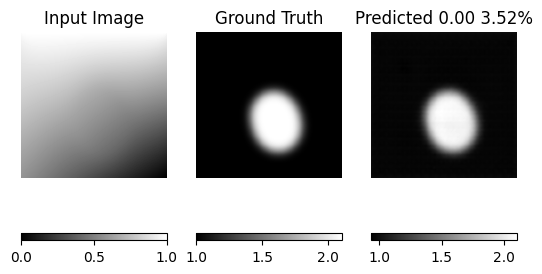

In [66]:
fit(train_dataset,val_dataset, epochs=EPOCH)

In [67]:
len(gen_total_loss_list)

15800

In [68]:
len(gen_val_loss_list)

400000

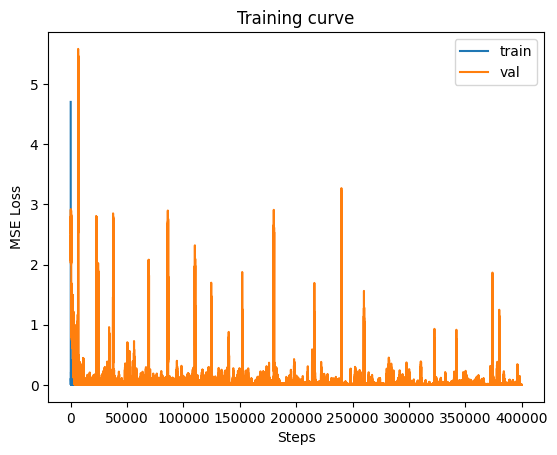

In [69]:
# plt.figure(figsize=(20, 15))
plt.plot(gen_total_loss_list, label='train')
plt.plot(gen_val_loss_list, label='val')
plt.title("Training curve")
plt.xlabel("Steps")
plt.ylabel("MSE Loss")
plt.legend()
plt.savefig('results/train_val_curve.png')
plt.show()


In [70]:
l1 = len(epoch_wise_train_loss)
l2 = len(epoch_wise_val_loss)
print(l1)
print(l2)
a = range(1,l1+1)
b = range(1,l2+1)

100
100


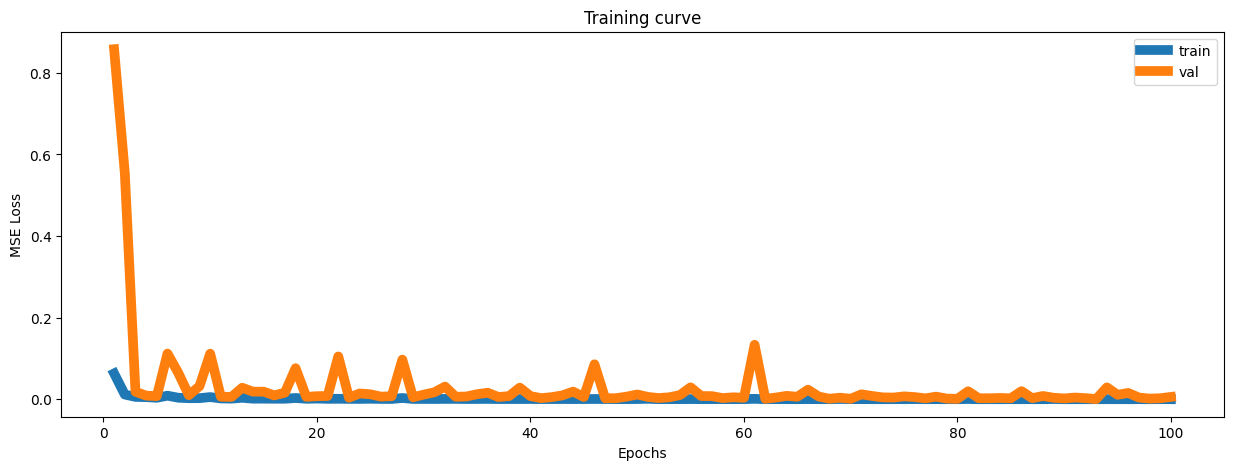

In [71]:
plt.figure(figsize=(15,5))
plt.plot(a, epoch_wise_train_loss, label='train', linewidth=7.0)
plt.plot(a, epoch_wise_val_loss, label='val', linewidth=7.0)
plt.title("Training curve")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.savefig('results/train_val_epoch_curve.png')
plt.show()

In [72]:
with open("epoch_wise_train_loss", "wb") as fp:   
    pickle.dump(epoch_wise_train_loss, fp)
with open("epoch_wise_val_loss", "wb") as fp:   
    pickle.dump(epoch_wise_val_loss, fp)

In [73]:
print(f'Train MSE at the end of training: {gen_total_loss_list[-1]}')
print(f'Val MSE at the end of training: {gen_val_loss_list[-1]}')

Train MSE at the end of training: 0.00018736542551778257
Val MSE at the end of training: 0.0002217933360952884


### Testing

In [63]:
generator.load_weights(BEST_PATH)

In [64]:
len(val_dataset)

1000

In [76]:
avg_mse_loss_list = []
avg_mape_loss_list = []

i = 0
for test_image,test_target in val_dataset:
    test_prediction = generator(test_image,training=True)
    test_target = test_target
    mse_loss = tf.keras.metrics.mean_squared_error(test_target, test_prediction)
    avg_mse_loss = tf.math.reduce_mean(mse_loss).numpy()
    avg_mse_loss_list.append(avg_mse_loss)

    mape_loss =  tf.keras.metrics.mean_absolute_percentage_error(test_target, test_prediction)
    avg_mape_loss = tf.math.reduce_mean(mape_loss).numpy()
    avg_mape_loss_list.append(avg_mape_loss)

    output = np.reshape(test_prediction, (128,128))
    gt = np.reshape(test_target, (128,128))
    i = i+1

    file_name = f"results/raw_vals/{i}-pred.raw"
    with open(file_name, 'wb') as fp:     
        output.tofile(fp)
    fp.close()

    file_name2 = f"results/raw_vals/{i}-gt.raw"
    with open(file_name2, 'wb') as fp:     
        gt.tofile(fp)
    fp.close()

2023-07-29 05:35:01.492710: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1000]
	 [[{{node Placeholder/_1}}]]


In [77]:
len(avg_mse_loss_list)

1000

In [78]:
final_mse = sum(avg_mse_loss_list)/len(avg_mse_loss_list)
with open(f'{RESULTS_FOLDER}/loss.txt','a') as f:
    f.write(f'\nFinal_MSE:{final_mse}')
final_mse

0.011729968114726944

In [79]:
len(avg_mape_loss_list)

1000

In [80]:
final_mape = sum(avg_mape_loss_list)/len(avg_mape_loss_list)
with open(f'{RESULTS_FOLDER}/loss.txt','a') as f:
    f.write(f'\nFinal_MAPE:{final_mape}')
final_mape

4.388431517481804

In [ ]:
generator.load_weights(BEST_PATH)

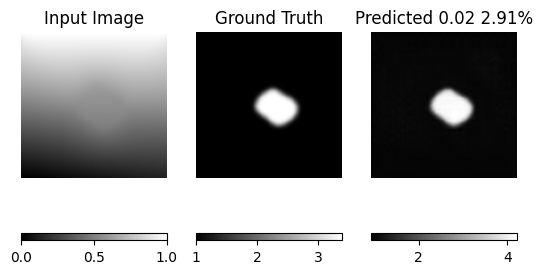

In [81]:
i = 0
for test_image,test_target in val_dataset:
    i = i+1
    generate_images(generator, test_image, test_target,'val-',i)

In [67]:
generator.load_weights(BEST_PATH)

In [99]:
i = 0
c = 0
for test_image,test_target in val_dataset:
    i = i+1
    generate_images8(generator, test_image, test_target,'val2222-',i)
    # c = c+1
    # if c==6:
    #     break

In [83]:
# Generate plots for test set
# for i, (test_input, test_target) in val_dataset.take(500).enumerate():
#     generate_images(generator, test_input, test_target,'test',i)

In [84]:
## Calculate modulus

In [85]:
# all_raw_data_path = 'raw_exps/*.raw'
# all_raw_data = glob.glob(all_raw_data_path)

In [86]:
# all_raw_data.sort(key=lambda x: int(x.split('/')[-1].split('.')[0]))
# all_raw_data

In [87]:
# threshold = 0.45

In [88]:
# all_modulus = []

In [89]:
# for a_data in all_raw_data:
#     img = np.fromfile(a_data,dtype = 'float32', sep="")
#     name = a_data.split('/')[-1].split('.')[0]
#     modulus = img[img<threshold]
#     if len(modulus) != 0:
#         avg_modulus = sum(modulus)/len(modulus)
    
#     all_modulus.append((name,avg_modulus))

#     with open('modulus_values.txt', 'a') as f:
#         f.write(f"{name},{avg_modulus}\n")
    
    

In [90]:
# for i in all_modulus:
#     print(i)